## Type 2 Diabetes Risk Prediction
This project analyzes whether a patient is likely to develop Type 2 Diabetes based on clinical variables.


## 1. Load and Prepare Data

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load dataset
df = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")

In [31]:
print(" Head of Dataset:")
print(df.head(), "\n")

# Show info summary
print(" Data Info:")
df.info()
print("\n")

# Count missing values
print(" Missing Values:")
print(df.isnull().sum(), "\n")

# Statistical summary
print(" Descriptive Statistics:")
print(df.describe())

 Head of Dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1   

 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1

## 2. Visualize Diabetese Distributions

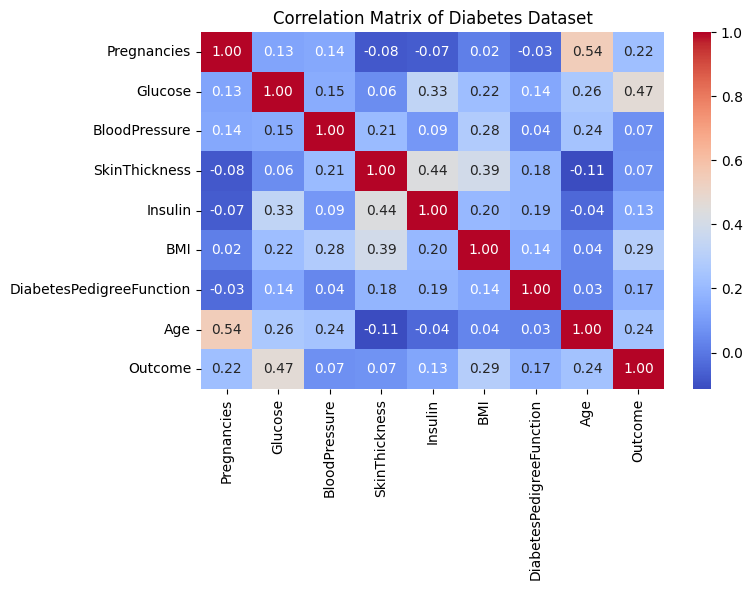

In [32]:
# Visualize the distribution of features and correlation
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Diabetes Dataset")
plt.tight_layout()
plt.show()

**Glucose** shows the strongest correlation with Outcome (~0.47), followed by BMI, Age, and Pregnancies — all meaningful for prediction.
On the other hand, features like **BloodPressure** and **SkinThickness** show low correlation with the target individually but may still contribute value when used in combination.

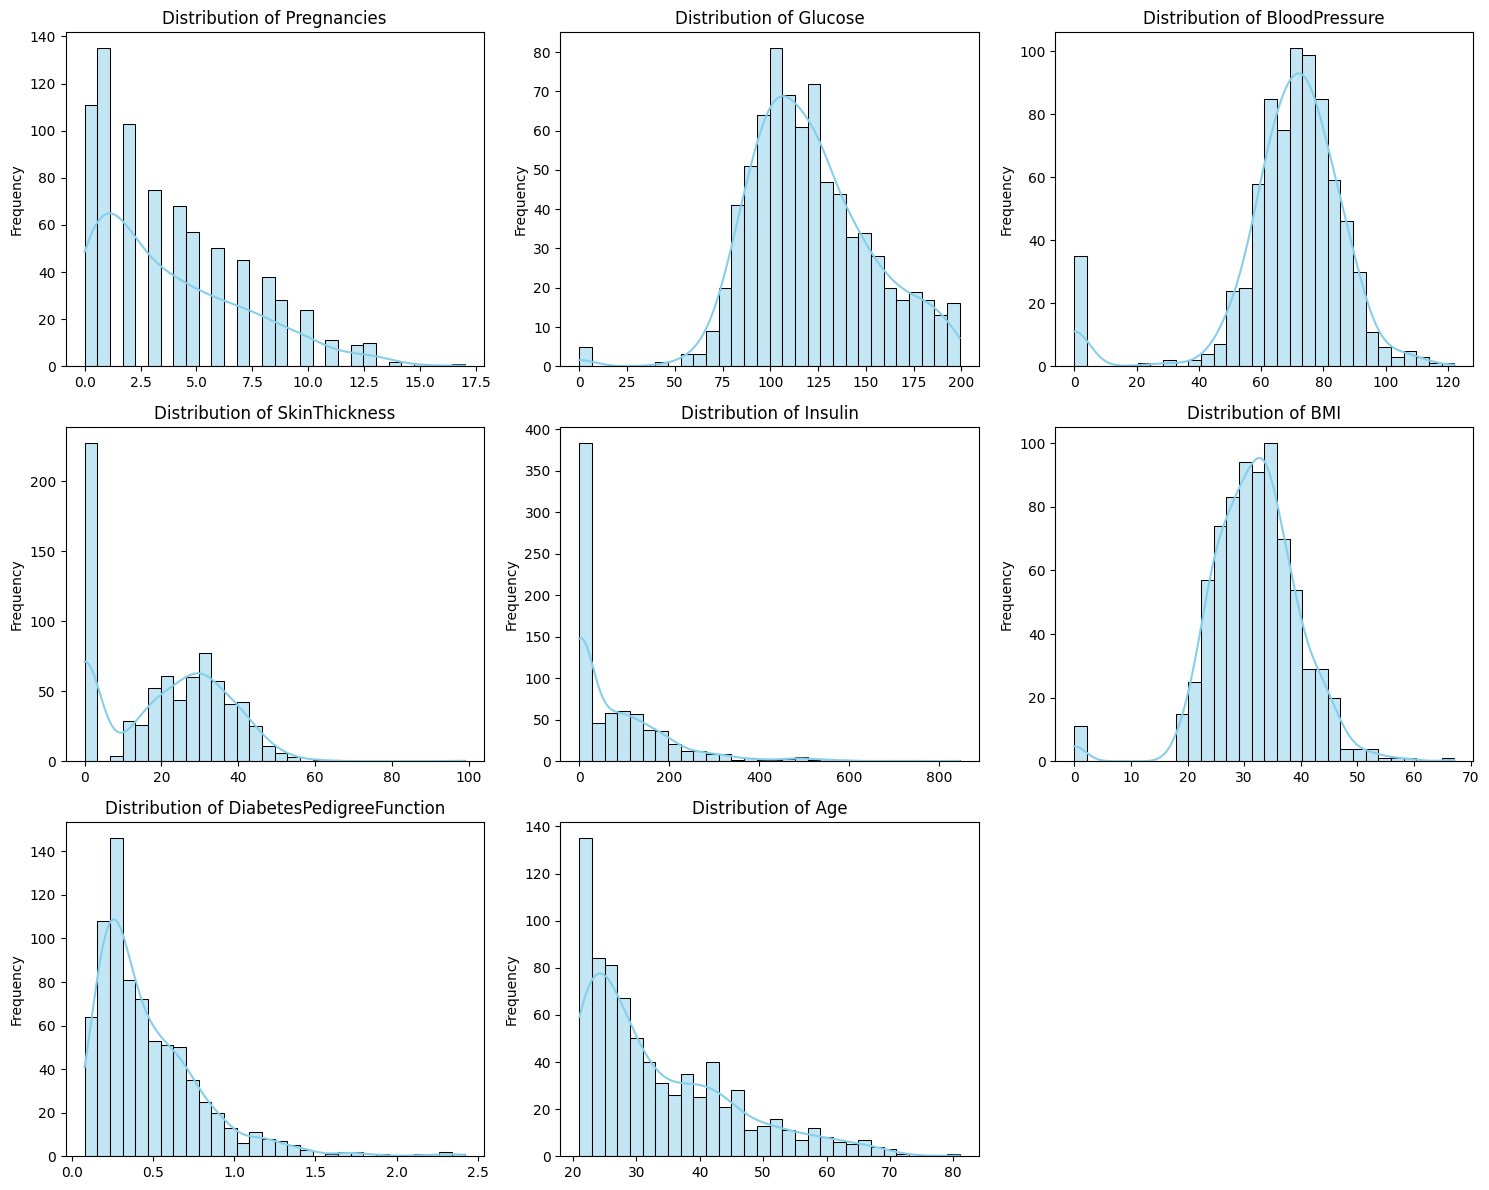

In [33]:
# Plot distributions for each feature
plt.figure(figsize=(15, 12))
for i, col in enumerate(df.columns[:-1]):  # skip 'Outcome'
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Here it can be seen that, several features like **Insulin, DiabetesPedigreeFunction, and SkinThickness** are right-skewed, which may affect model performance.
So we need to consider applying log transformation to those skewed features to normalize the distribution and reduce outlier impact.

## 3. Data Preparation for Model Training

In [43]:
#Log transformation
df['Insulin_log'] = np.log1p(df['Insulin'])

In [44]:
from sklearn.preprocessing import StandardScaler

# Columns where 0 is not a valid value
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace 0s with NaN in these columns
for col in columns_to_fix:
    df[col] = df[col].replace(0, np.nan)

# Impute missing values with mean
df[columns_to_fix] = df[columns_to_fix].fillna(df[columns_to_fix].mean())

# Scale the features (excluding Outcome)
features = df.drop('Outcome', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create final scaled dataframe
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['Outcome'] = df['Outcome'].values

In [45]:
scaled_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_log,Outcome
0,0.639947,0.865108,-0.033518,0.665502,0.000000,0.166292,0.468492,1.425995,0.237118,1
1,-0.844885,-1.206162,-0.529859,-0.017463,0.000000,-0.852531,-0.365061,-0.190672,0.237118,0
2,1.233880,2.015813,-0.695306,0.000000,0.000000,-1.332833,0.604397,-0.105584,0.237118,1
3,-0.844885,-1.074652,-0.529859,-0.700429,-0.724389,-0.634212,-0.920763,-1.041549,-0.745662,0
4,-1.141852,0.503458,-2.680669,0.665502,0.146551,1.548980,5.484909,-0.020496,0.387706,1


Here is the cleaned and standardized version of the diabetes dataset excluding TARGET column.

## 4. Model Training

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [57]:
# Features and target
X = scaled_df.drop(['Outcome'], axis=1)
y = scaled_df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define parameter grids
rf_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
log_param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

# GridSearchCV
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
log_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_param_grid, cv=5, scoring='accuracy')

# Fit the models
rf_grid.fit(X_train, y_train)
log_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='accuracy')

## 4: Evaluation

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
print("Logistic Regression")
print(classification_report(y_test, y_pred_log))
print("Best Logistic Regression:", log_grid.best_params_, "Accuracy:", log_grid.best_score_)

print("\n Random Forest")
print(classification_report(y_test, y_pred_rf))
print("Best Random Forest:", rf_grid.best_params_, "Accuracy:", rf_grid.best_score_)

Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154

Best Logistic Regression: {'C': 0.1} Accuracy: 0.7622550979608157

 Random Forest
              precision    recall  f1-score   support

           0       0.80      0.79      0.80        99
           1       0.63      0.65      0.64        55

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.74      0.74       154

Best Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100} Accuracy: 0.7785819005731042


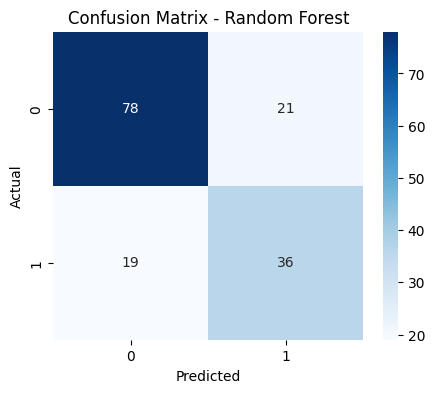

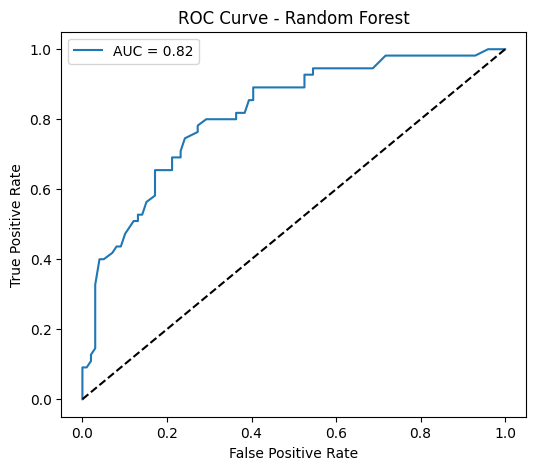

In [65]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

## 5. Explainablity

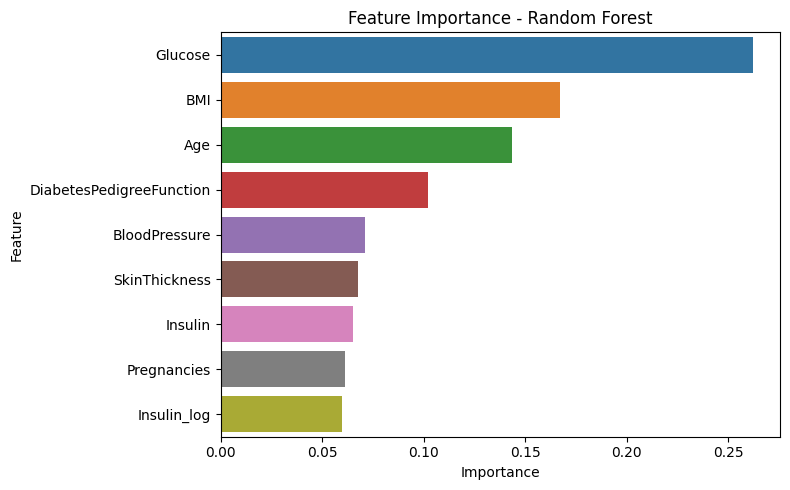

In [62]:
importances = rf_model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_df)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

- **Glucose**, **BMI**, and **Age** were the strongest predictors of Type 2 Diabetes.
- **Random Forest** performed better than Logistic Regression in terms of ROC-AUC and F1-score.
- The model can support public health planning by identifying high-risk individuals based on routine clinical features.